# **Breast Cancer - Grad-CAM Project**

Dataset link: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

In this project the Magnification factor is 400x.

## **Instalando as Bibliotecas** 

In [92]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
%matplotlib inline

import os
import pathlib
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras import backend as k

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU detected.')
else:
    print(f'Default GPU device: {tf.test.gpu_device_name()}')

Default GPU device: /device:GPU:0


In [4]:
# !nvidia-smi

## Get the Data 

In [6]:
# import zipfile
    
# # Unzip the download file
# zip_ref = zipfile.ZipFile('BreaKHis_v1.tar')
# zip_ref.extractall()
# zip_ref.close()

In [7]:
import tarfile

# Unzip the download file
my_tar = tarfile.open('BreaKHis_v1.tar.gz')
my_tar.extractall() # specify which folder to extract to
my_tar.close()

## Multi-class Image Classification: Let's break it down

1. Become one with the data (visualize, visualize, visualize)
2. preprocess the data (prepare it for our model, the main step here is scaling/normalizing and turning out data into batches)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model (try to beat our baseline)
7. Repeat until satisfied (experiment, experiment, experiment)

## 1. Become One with the Data 

### Inspecting the Data 

In [23]:
# %ls BreaKHis_v1
# %ls BreaKHis_v1\Experimento_1\

In [5]:
num_images = len(os.listdir('BreaKHis_v1/Experimento_1/'))

for dirpath, dirnames, filenames in os.walk('BreaKHis_v1/Experimento_1/'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

There are 2 directories and 2 images in BreaKHis_v1/Experimento_1/.
There are 8 directories and 0 images in BreaKHis_v1/Experimento_1/Test.
There are 0 directories and 25 images in BreaKHis_v1/Experimento_1/Test\adenosis.
There are 0 directories and 196 images in BreaKHis_v1/Experimento_1/Test\ductal_carcinoma.
There are 0 directories and 52 images in BreaKHis_v1/Experimento_1/Test\fibroadenoma.
There are 0 directories and 28 images in BreaKHis_v1/Experimento_1/Test\lobular_carcinoma.
There are 0 directories and 39 images in BreaKHis_v1/Experimento_1/Test\mucinous_carcinoma.
There are 0 directories and 32 images in BreaKHis_v1/Experimento_1/Test\papillary_carcinoma.
There are 0 directories and 26 images in BreaKHis_v1/Experimento_1/Test\phyllodes_tumor.
There are 0 directories and 31 images in BreaKHis_v1/Experimento_1/Test\tubular_adenoma.
There are 8 directories and 0 images in BreaKHis_v1/Experimento_1/Train.
There are 0 directories and 78 images in BreaKHis_v1/Experimento_1/Train\a

In [19]:
data_dir_train = pathlib.Path('BreaKHis_v1/Experimento_1/Train/')

# created a list of class_names from the subdirectory /train
class_names = np.array(sorted([item.name for item in data_dir_train.glob('*')]))
print(f'Types: {class_names}')

Types: ['adenosis' 'ductal_carcinoma' 'fibroadenoma' 'lobular_carcinoma'
 'mucinous_carcinoma' 'papillary_carcinoma' 'phyllodes_tumor'
 'tubular_adenoma']


### Visualizing Images

In [8]:
# os.listdir('BreaKHis_v1/Experimento_1/Train/benign/adenosis/')

In [4]:
# Visualizing images

def view_random_image(target_dir, target_class):
    # setup the target directory
    target_folder = target_dir + target_class
    
    # get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)
    
    # read in the image and plot using matplotlib
    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    
    print(f'Image shape: {img.shape}')
    
    return img

['SOB_B_A-14-22549CD-400-005.png']
Image shape: (460, 700, 3)
['SOB_B_F-14-23222AB-400-010.png']
Image shape: (460, 700, 3)
['SOB_B_PT-14-21998AB-400-023.png']
Image shape: (460, 700, 3)
['SOB_B_TA-14-16184CD-400-014.png']
Image shape: (460, 700, 3)


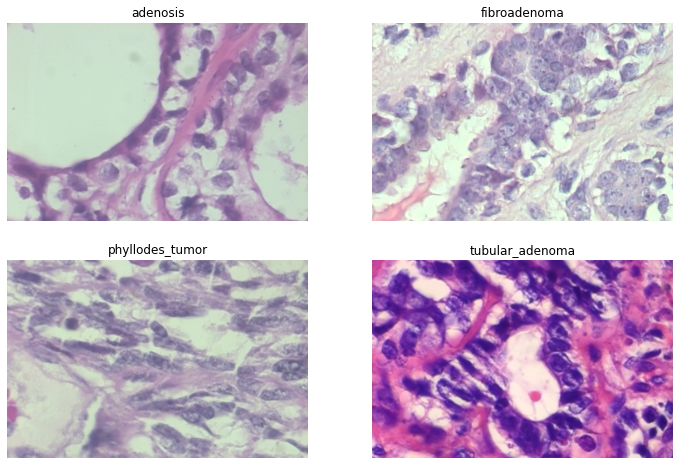

In [5]:
# view a random set of images from the training benign-dataset

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
img1 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='adenosis')

plt.subplot(2,2,2)
img2 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='fibroadenoma')

plt.subplot(2,2,3)
img3 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='phyllodes_tumor')

plt.subplot(2,2,4)
img4 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='tubular_adenoma')

['SOB_M_DC-14-11520-400-014.png']
Image shape: (460, 700, 3)
['SOB_M_LC-14-13412-400-011.png']
Image shape: (460, 700, 3)
['SOB_M_MC-14-12773-400-009.png']
Image shape: (460, 700, 3)
['SOB_M_PC-14-15704-400-010.png']
Image shape: (460, 700, 3)


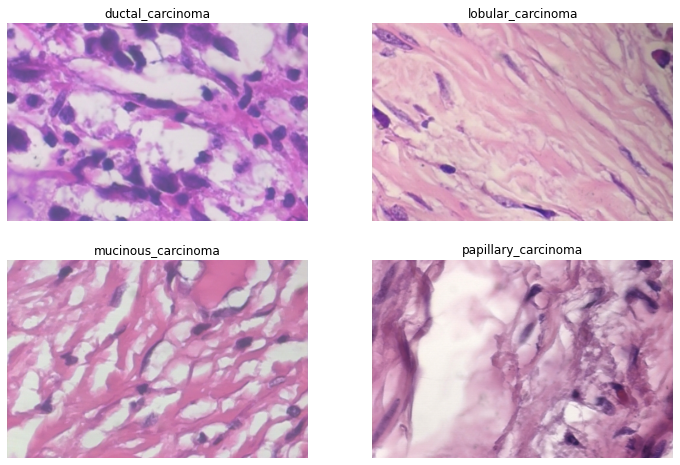

In [6]:
# view a random set of images from the training malignant-dataset

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
img1 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='ductal_carcinoma')

plt.subplot(2,2,2)
img2 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='lobular_carcinoma')

plt.subplot(2,2,3)
img3 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='mucinous_carcinoma')

plt.subplot(2,2,4)
img4 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='papillary_carcinoma')

In [8]:
# setting up the train and test directories

train_dir = 'BreaKHis_v1/Experimento_1/Train/'
test_dir = 'BreaKHis_v1/Experimento_1/Test/'

## 2. Preprocess the Data (Prepare it for the model)

In [9]:
# Rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32,
                                              class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32,
                                            class_mode='categorical')

Found 1365 images belonging to 8 classes.
Found 429 images belonging to 8 classes.


## 3. Create a Model (start with a baseline)

Take the model from the CNN explainer website and test it here.

In [ ]:
# create our model
model = Sequential([
    Conv2D(10,3,input_shape=(224,224,3), activation='relu'),
    Conv2D(10,3, activation='relu'),
    MaxPool2D(),
    
    Conv2D(10,3, activation='relu'),
    Conv2D(10,3, activation='relu'),
    MaxPool2D(),
    
    Flatten(),
    Dense(8,activation='softmax')
])

# compile our model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28090)            

## 4. Fit a Model 

In [19]:
# fit the model

history = model.fit(train_data, epochs=15, steps_per_epoch=len(train_data), validation_data=test_data,
                   validation_steps=len(test_data))

Epoch 1/15
43/43 [==============================] - 27s 625ms/step - loss: 1.4265 - accuracy: 0.4491 - val_loss: 1.6644 - val_accuracy: 0.4429
Epoch 2/15
43/43 [==============================] - 25s 587ms/step - loss: 1.1638 - accuracy: 0.5663 - val_loss: 1.7460 - val_accuracy: 0.4266
Epoch 3/15
43/43 [==============================] - 26s 611ms/step - loss: 0.8924 - accuracy: 0.6967 - val_loss: 2.0673 - val_accuracy: 0.4219
Epoch 4/15
43/43 [==============================] - 27s 616ms/step - loss: 0.5875 - accuracy: 0.8227 - val_loss: 2.2337 - val_accuracy: 0.4079
Epoch 5/15
43/43 [==============================] - 26s 611ms/step - loss: 0.3460 - accuracy: 0.9136 - val_loss: 2.7378 - val_accuracy: 0.3916
Epoch 6/15
43/43 [==============================] - 28s 653ms/step - loss: 0.2242 - accuracy: 0.9421 - val_loss: 3.3831 - val_accuracy: 0.3776
Epoch 7/15
43/43 [==============================] - 27s 626ms/step - loss: 0.1387 - accuracy: 0.9692 - val_loss: 3.1886 - val_accuracy: 0.3450

## 5. Evaluate the Model 

In [10]:
# Plot the validation and training curvers separately

def plot_loss_curves(history):
    """
    Returns separated loss curves for training and validation metrics.
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss'])) # how many epochs did we run for?
    
    plt.figure(figsize=(14,4))
    
    # plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    #plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label='accuracy')
    plt.plot(epochs, val_accuracy, label='validation_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [20]:
# Evaluate on the test data
model.evaluate(test_data)

14/14 [==============================] - 6s 394ms/step - loss: 4.7761 - accuracy: 0.4056


[4.776148796081543, 0.4055944085121155]

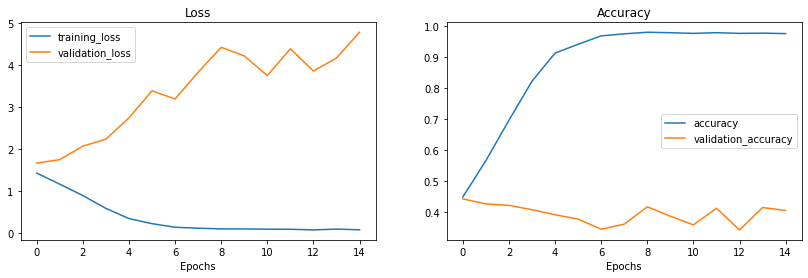

In [21]:
plot_loss_curves(history)

## 6. Adjust the model hyperparameters (to beat the baseline/ reduce overfitting) 

The model is learning something, but it's not generalizing well.
**How to prevent overfitting**:
* **Get more data** - having more data gives a mode more opportunity to learn diverse patterns...
* **Simplify the model** - if our current model is overfitting the data, it may be too complicated of a model, one way to simplify a model is to: reduce # of layers or reduce # hidden units in layers
* **Use Data Augmentation** - data augmentation manipulates the training data in such a way to add more diversity to it (without altering the original data)
* **Use Transfer Learning** - transfer learning leverages the patterns another model has learned on similar data to yout own and allows you to use those patterns on your own dataset.

In [11]:
# How about we try and simplify the model first?
# Let's try to remove 2 convolutional layers...

model_2 = Sequential([
    Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
    MaxPool2D(),
    
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    
    Flatten(),
    Dense(8, activation='softmax')
])

model_2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [12]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 29160)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 233288    
Total params: 234,478
Trainable params: 234,478
Non-trainable params: 0
__________________________________________________

In [13]:
history_2 = model_2.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=test_data,
                       validation_steps=len(test_data))

Epoch 1/5
43/43 [==============================] - 24s 548ms/step - loss: 1.7811 - accuracy: 0.4190 - val_loss: 1.7283 - val_accuracy: 0.4569
Epoch 2/5
43/43 [==============================] - 20s 476ms/step - loss: 1.6764 - accuracy: 0.4308 - val_loss: 1.6779 - val_accuracy: 0.4569
Epoch 3/5
43/43 [==============================] - 19s 450ms/step - loss: 1.5725 - accuracy: 0.4418 - val_loss: 1.6385 - val_accuracy: 0.4569
Epoch 4/5
43/43 [==============================] - 18s 413ms/step - loss: 1.3755 - accuracy: 0.4828 - val_loss: 1.5621 - val_accuracy: 0.4382
Epoch 5/5
43/43 [==============================] - 18s 410ms/step - loss: 1.1279 - accuracy: 0.6212 - val_loss: 1.5857 - val_accuracy: 0.4685


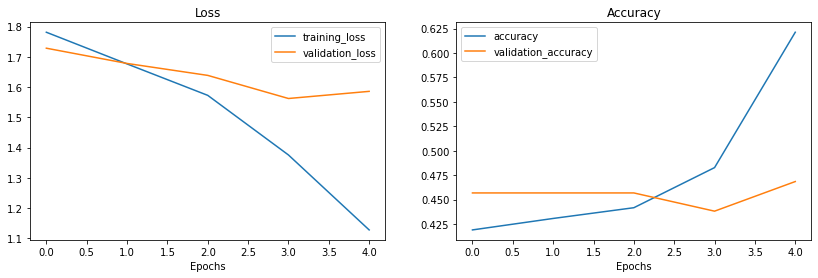

In [15]:
# Check out the loss curves
plot_loss_curves(history_2)

### Trying to Reduce Overfitting with Data Augmentation

Since simplifying the model didn't work, let's try and improve our model's results by using augmented training data...

Ideally, we want to:
* Reduce overfitting (get tge train and validation loss curves closer)
* Improve validation accuracy

In [13]:
# create an augmented data generator instance

# Rescale and augment
train_datagen_aug = ImageDataGenerator(rescale=1/255., rotation_range=0.2, width_shift_range=0.2,
                                      height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Load data in from directories and turn it into batches
train_data_aug = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32,
                                              class_mode='categorical')

Found 1365 images belonging to 8 classes.


In [14]:
# Let's create another model but this time we'll fit it on the augmented training data of 8 classes
model_3 = tf.keras.models.clone_model(model_2)

# compile the cloned model (using the same setup as previous models)
model_3.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [15]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 29160)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 233288    
Total params: 234,478
Trainable params: 234,478
Non-trainable params: 0
__________________________________________________

In [15]:
history_3 = model_3.fit(train_data_aug, epochs=5, steps_per_epoch=len(train_data_aug),
                        validation_data=test_data, validation_steps=len(test_data))

Epoch 1/5
43/43 [==============================] - 19s 445ms/step - loss: 1.6946 - accuracy: 0.4747 - val_loss: 1.5516 - val_accuracy: 0.5198
Epoch 2/5
43/43 [==============================] - 17s 387ms/step - loss: 1.5062 - accuracy: 0.5062 - val_loss: 1.4821 - val_accuracy: 0.5175
Epoch 3/5
43/43 [==============================] - 17s 388ms/step - loss: 1.2695 - accuracy: 0.5663 - val_loss: 1.5063 - val_accuracy: 0.4895
Epoch 4/5
43/43 [==============================] - 17s 390ms/step - loss: 1.1051 - accuracy: 0.6425 - val_loss: 1.4304 - val_accuracy: 0.5198
Epoch 5/5
43/43 [==============================] - 17s 394ms/step - loss: 0.9050 - accuracy: 0.7121 - val_loss: 1.6947 - val_accuracy: 0.5105


In [16]:
model_3.evaluate(test_data)

14/14 [==============================] - 4s 254ms/step - loss: 1.6947 - accuracy: 0.5105


[1.694671869277954, 0.5104895234107971]

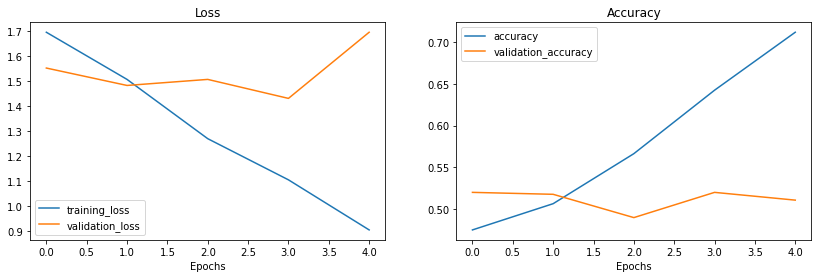

In [17]:
plot_loss_curves(history_3)

The loss curves are much closes to each other than the baseline model.

### 7. Repeat until satisfied

Possibilities:
- restructuring our model's architecture (increasing layers/ hidden units)
- adjust the learning rate
- try different methods of data augmentation (adjust the hyperparamenters in our ImageDataGenerator instance)
- training for longer (e.g. 10 epochs instead of 5 epochs)
- try **transfer learning** 

### Making a predicition with our trained model

Using the trained model to make some predictions on our custom images

In [20]:
class_names

array(['adenosis', 'ductal_carcinoma', 'fibroadenoma',
       'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma',
       'phyllodes_tumor', 'tubular_adenoma'], dtype='<U19')

> **Note:** When you train a neural network and you want to make a prediction with it on your own custom data, it's importante that the custom data (new data) is preprocessed into the same format as the data the model was trained on.

In [21]:
# Function that imports an image and resize it to be able to be used with the model

def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor and reshapes it to
    (img_shape, img_shape, colour_channels)
    """
    
    # Read in the image
    img = tf.io.read_file(filename)
    
    # Decode the read file to a tensor
#     img = tf.image.decode_png(img)
    img = tf.image.decode_image(img)
    
    # Resize the image
    img = tf.image.resize(img, size=[img_shape, img_shape])
    
    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    
    # Expand the image dimensions
#     img = tf.expand_dims(img, axis=0)
    
    
    return img

In [108]:
# for multiclass images
def pred_and_plot(model, filename, class_names=class_names):
    """
    Imports an image located at filename, makes a prediction with model and plots
    the image with the predicted class as title.
    """
    # Import the target image and process it
    img = load_and_prep_image(filename)
    img_tensor = tf.expand_dims(img, axis=0)
    
    # Make a prediction
    pred = model.predict(img_tensor)
    
    # Add in logic for multi-class & get pred_class name
    # Get the predicted class
    if len(pred[0]) > 1:
        top_pred_index = tf.argmax(pred[0])
        top_class_channel = pred[:,top_pred_index]
        pred_class = class_names[top_pred_index]
        prob = pred[0].max()
    else:
        top_pred_index = int(tf.round(pred[0]))
        top_class_channel = pred[:,top_pred_index]
        pred_class = class_names[top_pred_index]
        prob = tf.round(pred[0])
        
    last_conv_layer_name = 'conv2d_1'
    
    # Generate class activation heatmap
    heatmap = gradcam_heatmap(img_tensor, model, last_conv_layer_name)
    
    # superimpose heatmap on image
    img_heatmap = display_gradcam(img, heatmap)
    
    # Plot the image and predicted class
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f'Prediction: {pred_class}')
    plt.text(5,15, f'P: {round(prob*100,2)}%', fontweight='bold', bbox={'facecolor': 'white','pad': 2})
    plt.axis(False)
    
    plt.subplot(1,2,2)
    plt.title(f'Prediction: {pred_class}')
    plt.text(5,15, f'P: {round(prob*100,2)}%', fontweight='bold', bbox={'facecolor': 'white','pad': 2})
    plt.imshow(img_heatmap)

### Saving and Loading our model 

In [99]:
# Save a model

warnings.filterwarnings("ignore", category=DeprecationWarning) 

model_3.save('saved_trained_model_3')

INFO:tensorflow:Assets written to: saved_trained_model_3\assets


In [100]:
# Load in a trained model and evaluate it
loaded_model_3 = tf.keras.models.load_model('saved_trained_model_3/')
loaded_model_3.evaluate(test_data)

14/14 [==============================] - 4s 284ms/step - loss: 1.5151 - accuracy: 0.4988


[1.5151375532150269, 0.498834490776062]

In [101]:
# Compare our loaded model with our existing model
model_3.evaluate(test_data)

14/14 [==============================] - 4s 288ms/step - loss: 1.5151 - accuracy: 0.4988


[1.5151375532150269, 0.498834490776062]

### Implementing Grad-CAM to the model

Grad-Cam, unlike CAM, uses the gradient information flowing into the last convolutional layer of the CNN to understand each neuron for a decision of interest. 

In [87]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [107]:
def display_gradcam(img, heatmap, alpha=0.5):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

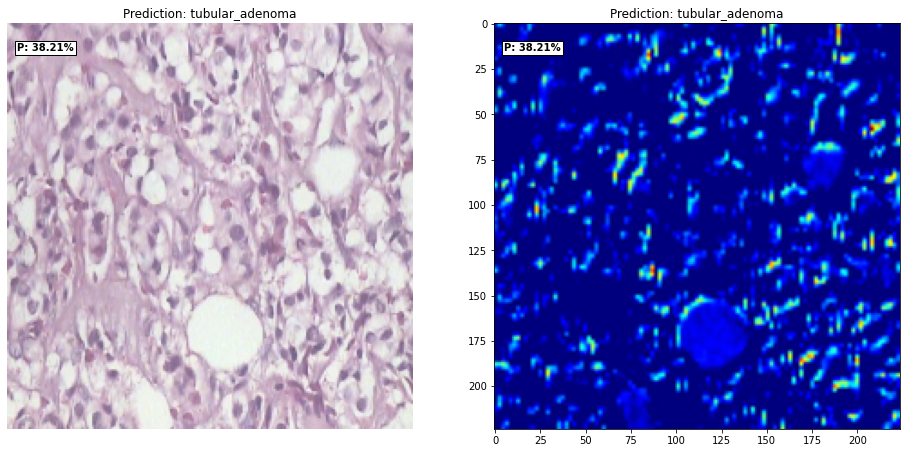

In [112]:
# Making the prediction
plt.figure(figsize=(16,12))
image = 'BreaKHis_v1/Amostras/SOB_M_MC-14-19979C-200-001.png'
pred_and_plot(model=model_3, filename=image, class_names=class_names)